### Limpieza de datos

In [9]:
import csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import plotly.graph_objects as go
from gtda.plotting import plot_point_cloud
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
import gudhi as gd



### Verificaciones

In [10]:
import pandas as pd
# Lee el archivo CSV especificando el delimitador y la columna de fechas
df = pd.read_csv('archivo_dividido.csv', delimiter=',', parse_dates=['Date'])

# Verifica que cada año avance coherentemente
def verificar_orden(dataframe):
    years = dataframe['Date'].dt.year.tolist()
    sorted_years = sorted(years)
    if years == sorted_years:
        print("Los años avanzan coherentemente en orden ascendente.")
    else:
        print("¡Error! Los años no avanzan coherentemente.")

verificar_orden(df)
df.head()

Los años avanzan coherentemente en orden ascendente.


,Date,January,February,March,April,May,June,July,August,September,October,November,December
0,1870-01-01,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871-01-01,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872-01-01,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873-01-01,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874-01-01,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14


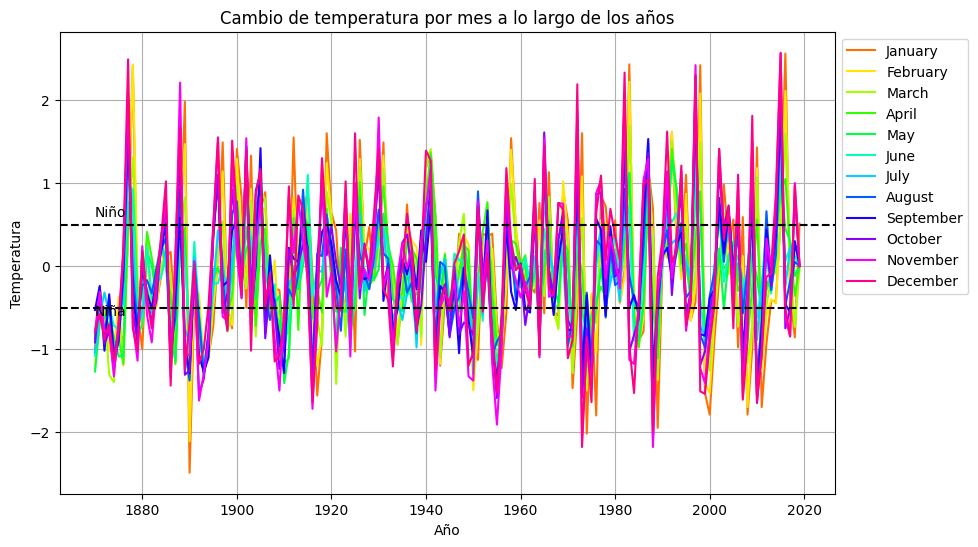

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que ya has leído y procesado los datos del archivo CSV como lo has hecho en tu código

# Crear una gráfica para mostrar el cambio de temperatura para cada mes a lo largo de todos los años
plt.figure(figsize=(10, 6))

# Conjunto para almacenar etiquetas únicas
used_labels = set()

# Definir una paleta de colores categóricos
palette = sns.color_palette("hsv", len(df.columns[1:]))

# Iterar sobre los meses y las columnas de temperatura
for month in range(1, 13):
    # Filtrar los datos para el mes actual
    month_data = df[df['Date'].dt.month == month]
    # Obtener la cantidad de datos para este mes
    num_data_points = month_data.shape[0]
    # Iterar sobre las columnas de temperatura y graficarlas si hay datos suficientes
    for i, col in enumerate(df.columns[1:]):
        # Verificar si la etiqueta ya se ha usado y si hay suficientes datos para graficar
        if col not in used_labels and num_data_points > 0:
            plt.plot(month_data['Date'], month_data[col], label=col, color=palette[i])
            used_labels.add(col)  # Agregar la etiqueta al conjunto de etiquetas usadas
    
# Configurar etiquetas y título
plt.xlabel('Año')
plt.ylabel('Temperatura')
plt.title('Cambio de temperatura por mes a lo largo de los años')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Agregar líneas horizontales para los umbrales y etiquetar las regiones
plt.axhline(y=-0.5, color='black', linestyle='--', label='Umbral -0.5 (Niña)')
plt.axhline(y=0.5, color='black', linestyle='--', label='Umbral 0.5 (Niño)')

# Agregar texto para etiquetar las regiones
plt.text(df['Date'].iloc[0], -0.6, 'Niña', fontsize=10, color='black')
plt.text(df['Date'].iloc[0], 0.6, 'Niño', fontsize=10, color='black')

plt.show()

In [12]:

# Extrae la variación de temperatura y el tiempo
temperatura = df.iloc[:, 1:].values.flatten()
#temperatura2 = df.iloc[1:60,1:].values.flatten()
tiempo = df["Date"].dt.year

# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=tiempo, 
    y=temperatura, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Variación de temperatura a lo largo del tiempo',
    xaxis=dict(title='Año'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()


In [13]:
def find_optimal_delay(x, maxtau=12):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

In [14]:
max_periodic_dimension=11
max_periodic_time_delay=11
stride=1
tau,d= takens_embedding_optimal_parameters(temperatura, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)


Optimal time delay:  10 
Optimal dimension:  8


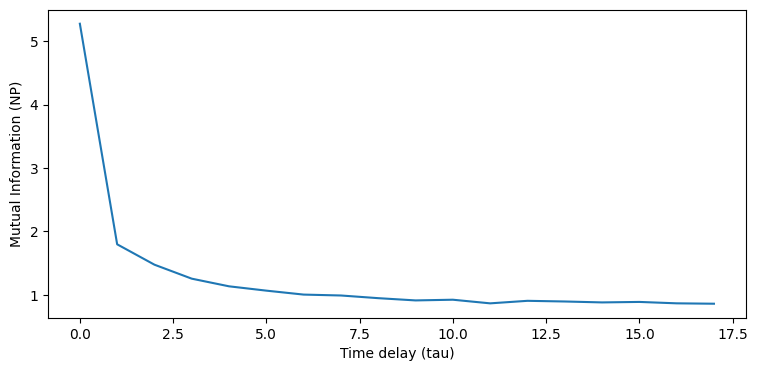

El primer mínimo local ocurre en: 9


In [15]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information (NP)')
plt.plot(delay.dmi(temperatura, maxtau=18))
plt.show()
print(f'El primer mínimo local ocurre en:',find_optimal_delay(temperatura, maxtau=18))


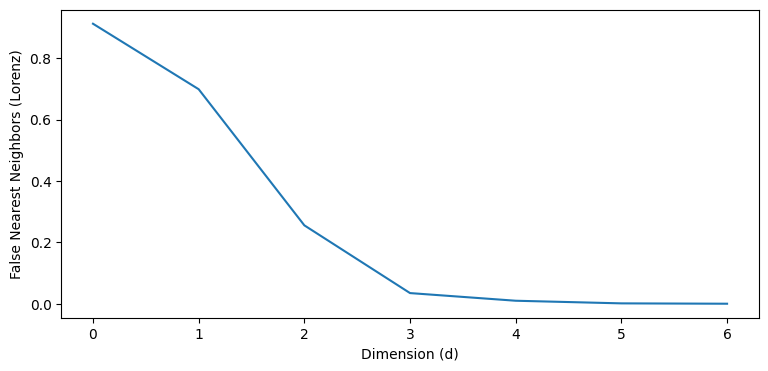

La dimensión óptima con tau=26 es:  3


In [16]:
test_dim = np.arange(1, 8)
f1, f2, f3 = dimension.fnn(x=np.array(temperatura.tolist()),
                           dim=test_dim,
                           tau=10,
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
plt.show()
print("La dimensión óptima con tau=26 es: ", [f<=0.1 for f in f1].index(True))

In [17]:
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=9,
    dimension=2,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(temperatura)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

Shape of embedded time series: (1791, 2)


#### DIVIDIR LAS FECHAS

In [18]:
# Divide los datos en dos DataFrames basados en el año
df_before_1940 = df[df['Date'].dt.year < 1940]
df_1940_and_after = df[df['Date'].dt.year >= 1940]

# Extrae los datos de temperatura
temperatura_before_1940 = df_before_1940.iloc[:, 1:].values.flatten()
temperatura_1940_and_after = df_1940_and_after.iloc[:, 1:].values.flatten()

y_periodic_embedded = embedder_periodic.fit_transform(temperatura)
y_periodic_embedded_p1 = embedder_periodic.fit_transform(temperatura_before_1940)
y_periodic_embedded_p2 = embedder_periodic.fit_transform(temperatura_1940_and_after)



#### FORMAS DE LOS DATOS

# 1: DATOS COMPLETOS 
# 2: DATOS MENORES QUE 1940
# 3: DATOS MAYORES QUE 1940

In [19]:
#1
print(f"Shape of embedded complete time series: {y_periodic_embedded.shape}")
#2
print(f"Shape of embedded time < 1940 time series: {y_periodic_embedded_p1.shape}")
#3
print(f"Shape of embedded time 1940 > series: {y_periodic_embedded_p2.shape}")
pca = PCA(n_components=2)
#DATOS COMPLETOS
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)


Shape of embedded complete time series: (1791, 2)
Shape of embedded time < 1940 time series: (831, 2)
Shape of embedded time 1940 > series: (951, 2)


In [20]:
#DATOS MENORES QUE 1940
y_periodic_embedded_pca1 = pca.fit_transform(y_periodic_embedded_p1)
plot_point_cloud(y_periodic_embedded_pca1)


In [21]:
#DATOS MAYORES QUE 1940
y_periodic_embedded_pca2 = pca.fit_transform(y_periodic_embedded_p2)
plot_point_cloud(y_periodic_embedded_pca2)

# CALCULAR PERSISTENCIAS CON LOS ENCAJADOS DE CADA PARTICION DE DATOS


c:\Users\ivana\AppData\Local\Programs\Python\Python39\lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning:

This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.



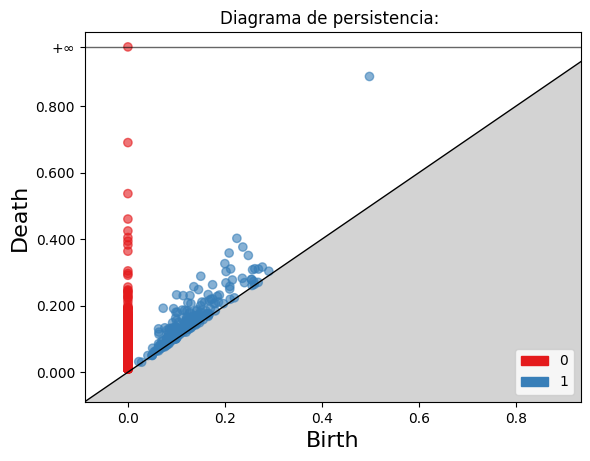

In [22]:
#DATOS MENORES QUE 1940
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded_p1, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_Circ = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_Circ);
plt.title(f'Diagrama de persistencia: ')
plt.show()



#### Como se puede observar en el diagrama de persistencia, estamos ante una figura de $b_ 0$ = 1 $b_ 1$ =1 por lo que se puede interpretar como un elipse y por ende: Periodico

# CALCULAR PERSISTENCIAS CON LOS ENCAJADOS DE CADA PARTICION DE DATOS


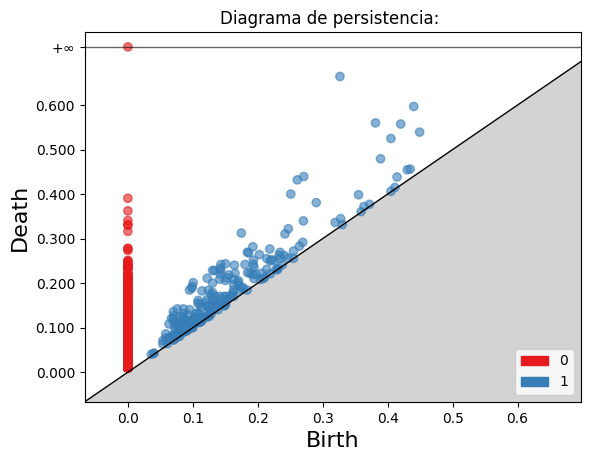

In [23]:
#DATOS MAYORES QUE 1940
skeletonCirc=gd.RipsComplex(points=y_periodic_embedded_p2, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_Circ = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_Circ);
plt.title(f'Diagrama de persistencia: ')
plt.show()


#### Como se puede observar en el diagrama los datos no son periodicos 

## AHORA CALCULAMOS LAS PERSISTENCIAS POR MES PARA COMPARAR Y ENCONTRAR POR QUÉ UN LAPSO DE TIEMPO SÍ ES PERIÓDICO

Calculando persistencias por mes y columna:   0%|          | 0/12 [00:00<?, ?it/s]

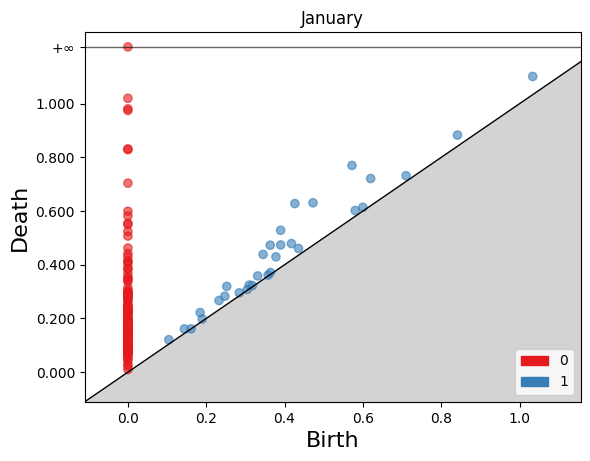

Calculando persistencias por mes y columna:   8%|▊         | 1/12 [00:00<00:01,  6.99it/s]

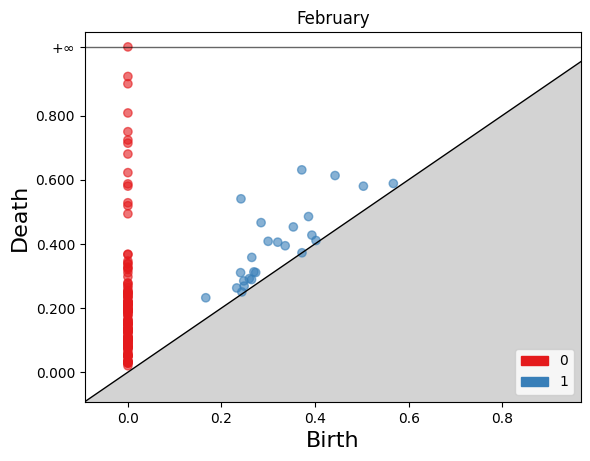

Calculando persistencias por mes y columna:  17%|█▋        | 2/12 [00:00<00:01,  5.84it/s]

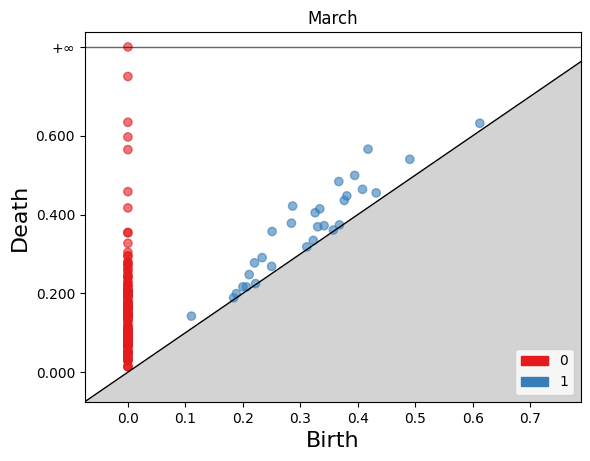

Calculando persistencias por mes y columna:  25%|██▌       | 3/12 [00:00<00:01,  4.95it/s]

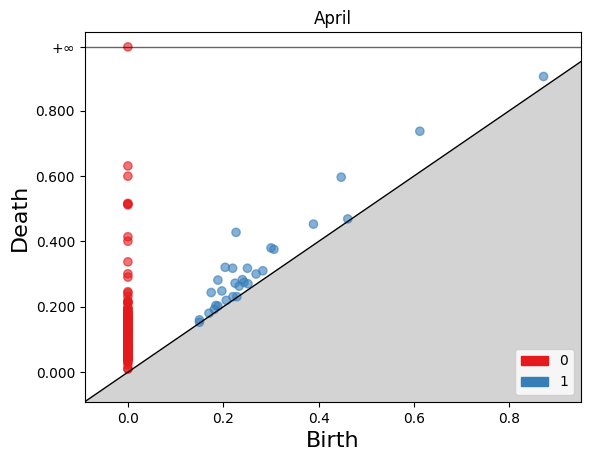

Calculando persistencias por mes y columna:  33%|███▎      | 4/12 [00:00<00:01,  4.41it/s]

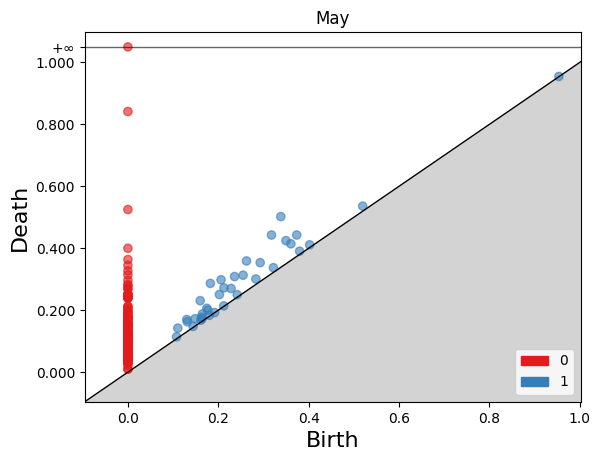

Calculando persistencias por mes y columna:  42%|████▏     | 5/12 [00:01<00:01,  4.20it/s]

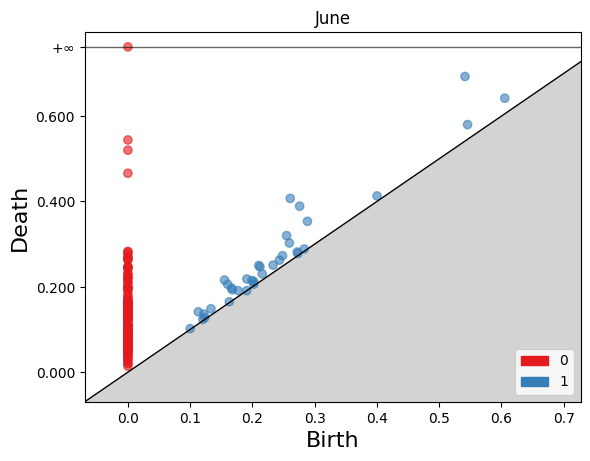

Calculando persistencias por mes y columna:  50%|█████     | 6/12 [00:01<00:01,  4.07it/s]

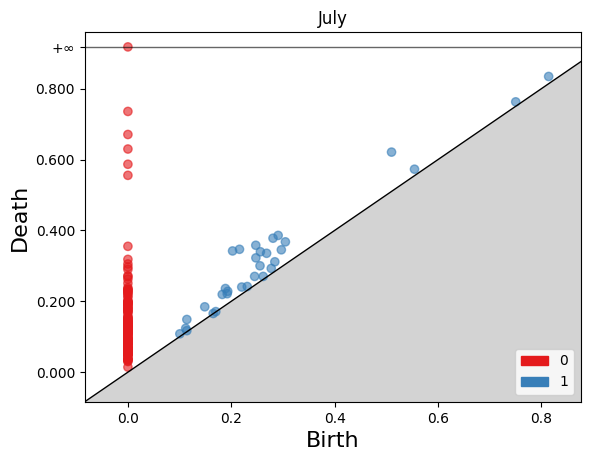

Calculando persistencias por mes y columna:  58%|█████▊    | 7/12 [00:01<00:01,  4.11it/s]

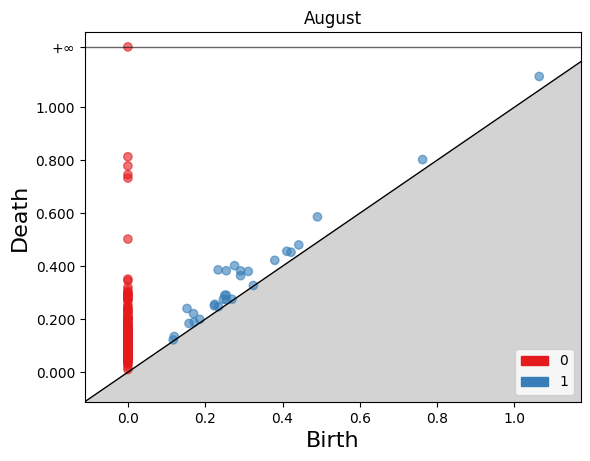

Calculando persistencias por mes y columna:  67%|██████▋   | 8/12 [00:01<00:00,  4.09it/s]

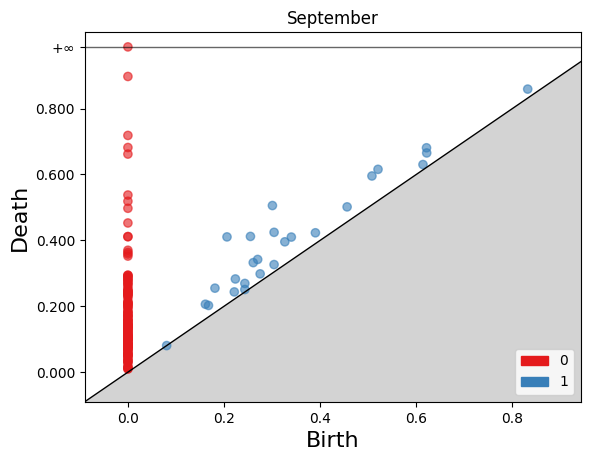

Calculando persistencias por mes y columna:  75%|███████▌  | 9/12 [00:02<00:00,  4.30it/s]

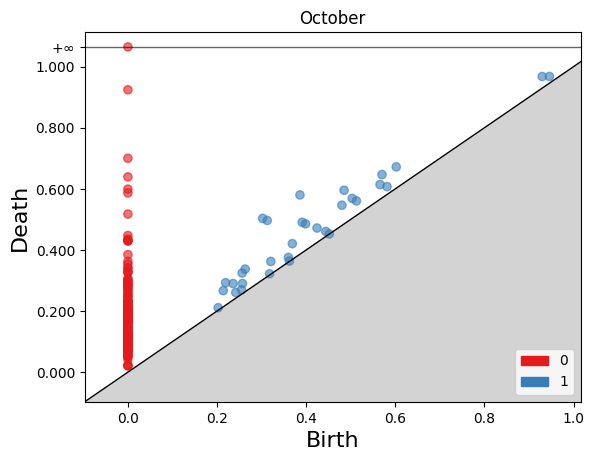

Calculando persistencias por mes y columna:  83%|████████▎ | 10/12 [00:02<00:00,  4.51it/s]

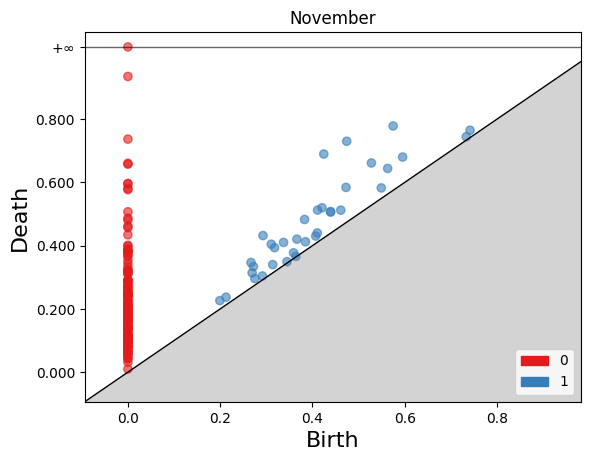

Calculando persistencias por mes y columna:  92%|█████████▏| 11/12 [00:02<00:00,  3.98it/s]

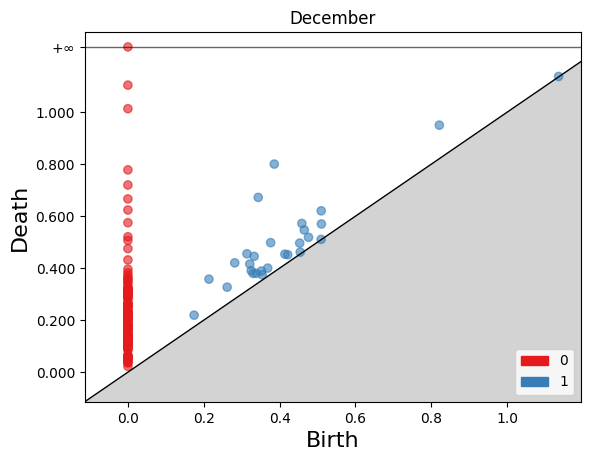

Calculando persistencias por mes y columna: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


In [69]:
from tqdm import tqdm

# Lista para almacenar los diagramas de persistencia por mes y por columna
persistencia_por_mes_y_columna = []
# Obtener la lista de meses únicos en los datos
unique_months = df['Date'].dt.month.unique()

# Iterar sobre cada columna de temperatura
for i, columna in enumerate(tqdm(df.columns[1:], desc="Calculando persistencias por mes y columna")):

    # Lista para almacenar los diagramas de persistencia para esta columna
    persistencia_por_columna = []
    
    # Iterar sobre cada mes único
    for mes in unique_months:
        # Filtrar los datos para el mes actual
        datos_mes = df[df['Date'].dt.month == mes]
        # Extraer los datos de temperatura para este mes y esta columna
        temperatura_mes_columna = datos_mes[columna].values
        
        # Aplicar el encaje de Takens a los datos mensuales
        datos_encajados_mes = embedder_periodic.fit_transform(temperatura_mes_columna)
        
        # Calcular las persistencias para los datos encajados
        skeleton_mes = gd.RipsComplex(points=datos_encajados_mes, max_edge_length=2)
        simplex_tree_mes = skeleton_mes.create_simplex_tree(max_dimension=2)
        barcodes_mes = simplex_tree_mes.persistence()
        
        # Agregar el diagrama de persistencia a la lista
        persistencia_por_columna.append(barcodes_mes)
    
    # Graficar el diagrama de persistencia para esta columna en los ejes correspondientesaaa
    for persistencia_mes in persistencia_por_columna:
        # Crear el título con el nombre de la columna
        titulo = f"{columna}"
        
        # Crear la gráfica de persistencia con el título
        gd.plot_persistence_diagram(persistencia_mes)
        plt.title(titulo)
        plt.show()
